In [1]:
import os, re, sys, random, math, json, joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from xgboost import XGBRegressor

from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Normalization, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor

In [2]:
SEED = 34


os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

ERROR_MARGIN_G = 2

BATCH_SIZE=256
MAX_TRIALS=50
EPOCHS=50

CALLBACKS = [
    EarlyStopping(
        monitor="val_mean_absolute_error",
        min_delta=0.005,
        patience=8,
        mode="min",
        restore_best_weights=True,
        verbose=0
    ),
    ReduceLROnPlateau(
        monitor="val_mean_absolute_error",
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        mode="min",
        verbose=0
    )
]

In [3]:
df = pd.DataFrame(pd.read_csv('3d_print_miniatures_base.csv'))

In [4]:
df.describe()

,artist,mini,kb,volume,surface_area,bbox_x,bbox_y,bbox_z,bbox_area,mass,euler_number,scale,weight,base_mm
count,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,1.288800e+04,12888.000000,12888.000000,12888.000000,12887.000000,11602.000000
mean,0.757837,1210.681642,39134.951852,14555.546906,31609.097182,43.593562,34.885004,50.215750,1.482449e+05,14555.546906,4366.614215,76.762979,14.498485,57.721944
std,0.749289,666.207804,41068.365122,22317.718749,46584.665163,27.860584,20.960410,29.334768,5.993805e+05,22317.718749,18333.158356,42.690615,23.691328,41.094890
min,0.000000,0.000000,727.132812,-383.257131,39.938355,3.540864,2.777933,2.887104,3.917259e+01,-383.257131,-126586.000000,6.317293,0.014785,15.000000
25%,0.000000,627.000000,6452.596680,1711.129269,5156.569357,24.325485,20.660660,28.295200,1.531937e+04,1711.129269,505.000000,46.302266,1.527586,30.000000
50%,1.000000,1232.000000,27246.712891,5349.788956,13512.230290,35.004646,30.806185,43.407283,4.590776e+04,5349.788956,1380.000000,66.435881,5.063407,50.000000
75%,1.000000,1792.000000,54880.794922,17298.943933,35962.199213,56.913000,46.611198,65.035666,1.463975e+05,17298.943933,3663.250000,98.369377,17.061743,75.000000
max,2.000000,2343.000000,429450.863281,314692.280269,484544.629610,223.300697,1173.446252,513.482544,6.136918e+07,314692.280269,737690.000000,1284.917846,693.495100,420.000000


In [5]:
df.head()

,artist,mini,kb,volume,surface_area,bbox_x,bbox_y,bbox_z,bbox_area,mass,euler_number,scale,weight,base_mm
0,1,1566,57773.031250,26671.484162,62721.738592,51.132734,63.831800,63.733878,208020.653476,26671.484162,4579,103.687330,26.895716,50.0
1,0,2114,3795.785156,279.380305,1028.552066,12.985000,10.738600,12.474300,1739.425358,279.380305,149,20.965112,0.241786,50.0
2,0,2115,20591.195312,12494.153312,27990.725314,60.528799,23.654200,47.155201,67514.944409,12494.153312,3264,80.292401,11.668830,50.0
3,0,10,30708.968750,6960.442344,22507.570367,47.551899,35.269100,38.413200,64423.265760,6960.442344,3855,70.573837,6.165829,30.0
4,1,299,26519.808594,3515.383904,8609.005976,28.039989,26.600918,26.896539,20061.844546,3515.383904,1412,47.087935,3.588529,25.0


In [6]:
print(f"--- ARTISTS ({df['artist'].nunique()})---")
print(sorted(df['artist'].unique()))

print()
print(f"--- MINIS ({df['mini'].nunique()})---")
minis = sorted(df['mini'].unique())
print(minis[:10])

--- ARTISTS (3)---
[np.int64(0), np.int64(1), np.int64(2)]

--- MINIS (2344)---
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


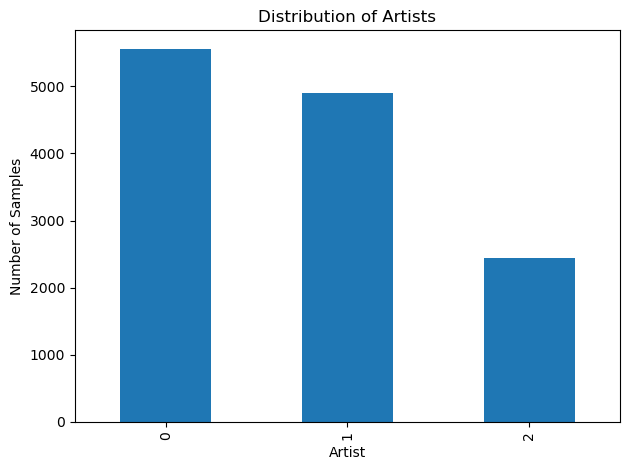

In [7]:
plt.figure()
df["artist"].value_counts().plot(kind="bar")
plt.xlabel("Artist")
plt.ylabel("Number of Samples")
plt.title("Distribution of Artists")
plt.tight_layout()
plt.show()

In [8]:
parts_per_mini = df.groupby("mini").size()

avg_parts = parts_per_mini.mean()
max_parts = parts_per_mini.max()
min_parts = parts_per_mini.min()

print("Average parts per mini:", avg_parts)
print("Max parts for a mini:", max_parts)
print("Min parts for a mini:", min_parts)

Average parts per mini: 5.498293515358362
Max parts for a mini: 61
Min parts for a mini: 1


In [9]:
def is_nan_columns(df):
    nan_rows = None
    if df.isnull().values.any():
        print("Dataset contains NaN values.")
    
        nan_counts = df.isnull().sum()
        print("NaN counts in each column:")
        print(nan_counts[nan_counts > 0])

        print()
        
        nan_rows = df[df.isnull().any(axis=1)]

    return nan_rows

df_nans = is_nan_columns(df)

Dataset contains NaN values.
NaN counts in each column:
weight        1
base_mm    1286
dtype: int64



In [10]:
df.dropna(subset=['weight'], inplace=True)
df["base_mm"] = df["base_mm"].fillna(0)

In [11]:
def preprocess_df(df):
    tmp = df.copy()
    tmp['kb']     = tmp['kb'].astype(int)
    tmp['volume'] = np.ceil(tmp['volume'] * 10) / 10

    # Polynomial Features
    tmp['volume_g'] = tmp['volume'] * 1e-3 * 1.1
    tmp['mass_g']   = tmp['mass']  * 1e-3 * 1.1
    
    # Interaction Features
    tmp['volume_mass_interaction'] = tmp['volume_g'] * tmp['mass_g']
    tmp['surface_volume_ratio'] = tmp['surface_area'] / tmp['volume']
    tmp['bbox_volume_ratio'] = tmp['bbox_area'] / tmp['volume']
    
    # Dimension Ratios
    tmp['surface_mass_ratio'] = tmp['surface_area'] / df['mass']
    tmp['bbox_mass_ratio'] = tmp['bbox_area'] / df['mass']

    for col in ['surface_area', 'bbox_x', 'bbox_y', 'bbox_z', 'bbox_area', 'weight', 'scale',
                'volume', 'volume_g', 'mass', 'mass_g', 'volume_mass_interaction', 'surface_volume_ratio', 'surface_mass_ratio']:
        tmp[col] = tmp[col].round(1)

    return tmp

df = preprocess_df(df)

In [12]:
df.head()

,artist,mini,kb,volume,surface_area,bbox_x,bbox_y,bbox_z,bbox_area,mass,...,scale,weight,base_mm,volume_g,mass_g,volume_mass_interaction,surface_volume_ratio,bbox_volume_ratio,surface_mass_ratio,bbox_mass_ratio
0,1,1566,57773,26671.5,62721.7,51.1,63.8,63.7,208020.7,26671.5,...,103.7,26.9,50.0,29.3,29.3,860.8,2.4,7.799361,2.4,7.799366
1,0,2114,3795,279.4,1028.6,13.0,10.7,12.5,1739.4,279.4,...,21.0,0.2,50.0,0.3,0.3,0.1,3.7,6.225574,3.7,6.226013
2,0,2115,20591,12494.2,27990.7,60.5,23.7,47.2,67514.9,12494.2,...,80.3,11.7,50.0,13.7,13.7,188.9,2.2,5.403703,2.2,5.403723
3,0,10,30708,6960.5,22507.6,47.6,35.3,38.4,64423.3,6960.4,...,70.6,6.2,30.0,7.7,7.7,58.6,3.2,9.255551,3.2,9.255628
4,1,299,26519,3515.4,8609.0,28.0,26.6,26.9,20061.8,3515.4,...,47.1,3.6,25.0,3.9,3.9,15.0,2.4,5.706845,2.4,5.706872


In [13]:
def plot_feature_distribution_with_bounds(df, feature, q1=0.25, q3=0.85, factor=1.5, bins=100, artist=None):
    col = df[feature]
    Q1 = col.quantile(q1)
    Q3 = col.quantile(q3)
    IQR = Q3 - Q1
    upper_bound = Q3 + factor * IQR

    plt.figure()
    plt.hist(col, bins=bins)
    plt.axvline(upper_bound, linestyle="--")
    plt.xlabel(feature)
    plt.ylabel("count")
    plt.title(f"{feature} distribution with IQR bounds - Artist: {artist}")
    plt.tight_layout()
    plt.show()

    print(f"{feature} Q1={Q1:.3f}, Q3={Q3:.3f}, IQR={IQR:.3f}")
    print(f"Upper Bound:{upper_bound:.3f}")

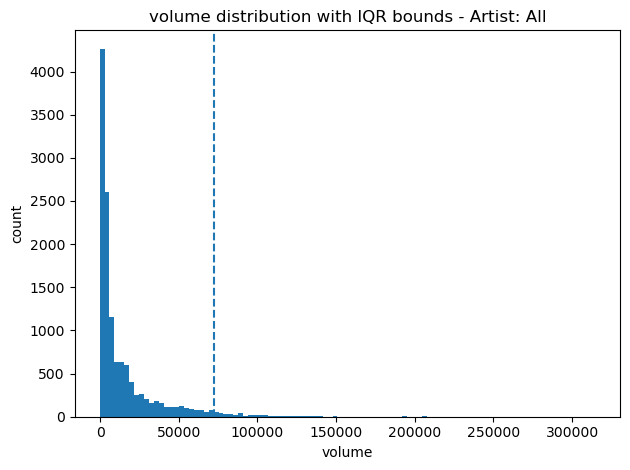

volume Q1=1710.900, Q3=29866.670, IQR=28155.770
Upper Bound:72100.325


In [14]:
plot_feature_distribution_with_bounds(df, feature='volume', artist='All')

In [15]:
def remove_outliers(df, features, q1=0.25, q3=0.85, factor=1.5):
    if isinstance(features, str):
        features = [features]

    cols = df[features]

    Q1 = cols.quantile(q1)
    Q3 = cols.quantile(q3)
    IQR = Q3 - Q1

    upper_bounds = Q3 + factor * IQR

    outlier_flags = cols > upper_bounds
    row_outlier = outlier_flags.any(axis=1)

    mask = ~row_outlier

    print("Upper bounds:")
    print(upper_bounds)
    print(f"→ keeping {mask.sum()} / {len(df)} rows")

    return df[mask]

df = remove_outliers(df, features=['volume'])

Upper bounds:
volume    72100.325
dtype: float64
→ keeping 12479 / 12887 rows


In [16]:
def split_dataset(df, target, test_size, seed, stratified=False, stratified_column=None, num_bins=4):
    tmp = df.copy()

    if stratified and stratified_column:
        tmp["stratified_bins"] = pd.qcut(
            tmp[stratified_column],
            q=num_bins,
            duplicates="drop"
        )
        stratify_col = tmp["stratified_bins"]
    else:
        stratify_col = None

    X = tmp.drop(columns=[target])
    y = tmp[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=seed,
        stratify=stratify_col
    )

    if stratified and stratified_column:
        X_train = X_train.drop(columns=["stratified_bins"])
        X_test = X_test.drop(columns=["stratified_bins"])

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_dataset(df, 'weight', 0.2, SEED, stratified=True, stratified_column='volume')

In [17]:
def build_and_compile_model(hp, n_features, normalizer):
    model = Sequential()
    model.add(Input(shape=(n_features,)))
    model.add(normalizer)

    init_units = hp.Int("init_units", min_value=448, max_value=710, step=16)
    num_dense_layers = hp.Int("num_dense_layers", min_value=2, max_value=3)

    regularizer = hp.Choice("regularizer", values=["none", "l2"])
    l2_str = hp.Float("l2_str", min_value=2e-6, max_value=1e-5, sampling="log")

    if regularizer == "none":
        kernel_regularizer = None
    else:
        kernel_regularizer = l2(l2_str)

    tested_activations = ["selu", "mish"]

    model.add(Dense(init_units, kernel_regularizer=kernel_regularizer))
    model.add(Activation(hp.Choice("init_activation", values=tested_activations)))

    if hp.Choice("init_batch_normalization", values=[True, False]):
        model.add(BatchNormalization())

    units_0 = hp.Int(f"units_0", min_value=441, max_value=768, step=16)
    use_bn = hp.Choice(f"batch_normalization_0", values=[True, False])

    model.add(Dense(units_0, kernel_regularizer=kernel_regularizer))
    if use_bn:
        model.add(BatchNormalization())

    model.add(Activation(hp.Choice(f"activation_0", values=tested_activations)))

    dropout_rate = hp.Choice(f"dropout_0", values=[0.0, 0.2, 0.3])
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    units_1 = hp.Int(f"units_1", min_value=448, max_value=710, step=16)
    use_bn = hp.Choice(f"batch_normalization_1", values=[True, False])

    model.add(Dense(units_1, kernel_regularizer=kernel_regularizer))
    if use_bn:
        model.add(BatchNormalization())

    model.add(Activation(hp.Choice(f"activation_1", values=tested_activations)))

    dropout_rate = hp.Choice(f"dropout_1", values=[0.0, 0.2, 0.3, 0.4])
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    if num_dense_layers == 3:
        units_2 = hp.Int(f"units_2", min_value=384, max_value=595, step=16)
        use_bn = hp.Choice(f"batch_normalization_2", values=[True, False])
    
        model.add(Dense(units_2, kernel_regularizer=kernel_regularizer))
        if use_bn:
            model.add(BatchNormalization())
    
        model.add(Activation(hp.Choice(f"activation_2", values=tested_activations)))
    
        dropout_rate = hp.Choice(f"dropout_2", values=[0.0, 0.2, 0.3])
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    opt_name = hp.Choice("optimizer", values=["adam", "adamw"])
    learning_rate = hp.Float("learning_rate", min_value=6e-4, max_value=9e-4, sampling="log")

    if opt_name == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = AdamW(learning_rate=learning_rate)

    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=[MeanAbsoluteError()])
    return model

def search_best_model(project_name, x, y, seed, epochs=50, max_trials=10, split=0.2, batch_size=None, show_model=True):
    x = np.array(x, dtype=np.float32)
    n_features = x.shape[1]

    normalizer = Normalization(axis=-1)
    normalizer.adapt(x)

    tuner = kt.BayesianOptimization(
        lambda hp: build_and_compile_model(hp, n_features, normalizer),
        objective=kt.Objective("val_mean_absolute_error", direction="min"),
        max_trials=max_trials,
        directory='bayesian_optimization',
        project_name=project_name,
        seed=seed
    )

    tuner.search(
        x, y,
        epochs=epochs,
        validation_split=split,
        batch_size=batch_size,
        callbacks = CALLBACKS,
    )
    
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model_from_tuner = tuner.hypermodel.build(best_hps)

    if show_model:
        print("Best Model from Tuner:")
        best_model_from_tuner.summary()

    return best_hps, best_model_from_tuner, tuner

def show_best_hps(hps):
    print("Best Hyperparameters:")
    for hp in hps.values:
        print(f"{hp}: {hps.get(hp)}")

In [18]:
%%time

best_hps, best_model, tuner = search_best_model('All_Artists', X_train, y_train, epochs=EPOCHS, max_trials=MAX_TRIALS, seed=SEED, batch_size=BATCH_SIZE)
show_best_hps(best_hps)

Trial 50 Complete [00h 00m 18s]
val_mean_absolute_error: 0.6457105278968811

Best val_mean_absolute_error So Far: 0.4521239399909973
Total elapsed time: 00h 16m 09s
Best Model from Tuner:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 20)             │            41 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 528)            │        11,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 528)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 649)            │       343,321 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 649)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 649)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 448)            │       291,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           449 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,099 (2.46 MB)

 Trainable params: 646,058 (2.46 MB)

 Non-trainable params: 41 (168.00 B)

Best Hyperparameters:
init_units: 528
num_dense_layers: 2
regularizer: none
l2_str: 6.579054493984083e-06
init_activation: mish
init_batch_normalization: 0
units_0: 649
batch_normalization_0: 0
activation_0: selu
dropout_0: 0.3
units_1: 448
batch_normalization_1: 0
activation_1: mish
dropout_1: 0.4
optimizer: adamw
learning_rate: 0.0007412055729664756
units_2: 480
batch_normalization_2: 1
activation_2: selu
dropout_2: 0.0
CPU times: user 49min 34s, sys: 23min 21s, total: 1h 12min 55s
Wall time: 16min 8s


In [19]:
def build_and_fit_from_hps(best_hps, X_train, y_train, X_test, y_test):
    X_train = np.array(X_train, dtype=np.float32)
    n_features = X_train.shape[1]

    normalizer = Normalization(axis=-1)
    normalizer.adapt(X_train)

    model = build_and_compile_model(best_hps, n_features, normalizer)
    history = model.fit(
        X_train, y_train,
        validation_split=0.3,
        epochs=100,
        batch_size=BATCH_SIZE,
        callbacks=CALLBACKS,
        verbose=1
    )
    mae = model.evaluate(X_test, y_test, verbose=1)[1]
    return history, model, mae

In [20]:
features = [
    'artist',
    'volume',
    'mass',
    'volume_mass_interaction',
    'surface_volume_ratio',
    'surface_mass_ratio',
    'base_mm',
    'euler_number'
]

In [21]:
%%time

X_train = X_train[features]
X_test  = X_test[features]

history, model, mae = build_and_fit_from_hps(best_hps, X_train, y_train, X_test, y_test)

print("MAE: ", mae)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 124.9594 - mean_absolute_error: 7.9402 - val_loss: 22.6960 - val_mean_absolute_error: 4.0651 - learning_rate: 7.4121e-04
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.4869 - mean_absolute_error: 2.8094 - val_loss: 5.7700 - val_mean_absolute_error: 1.3490 - learning_rate: 7.4121e-04
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.9737 - mean_absolute_error: 1.6130 - val_loss: 4.4161 - val_mean_absolute_error: 1.1428 - learning_rate: 7.4121e-04
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5211 - mean_absolute_error: 1.3661 - val_loss: 3.6289 - val_mean_absolute_error: 0.8581 - learning_rate: 7.4121e-04
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7585 - mean_absolute_error: 1.1941 - val_loss: 3.5640 - val_mean_absolute_error: 0.7897 - learning_rate: 7.4121e-04
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5108 - mean_absolute_error: 1.1654 - val_loss: 3.

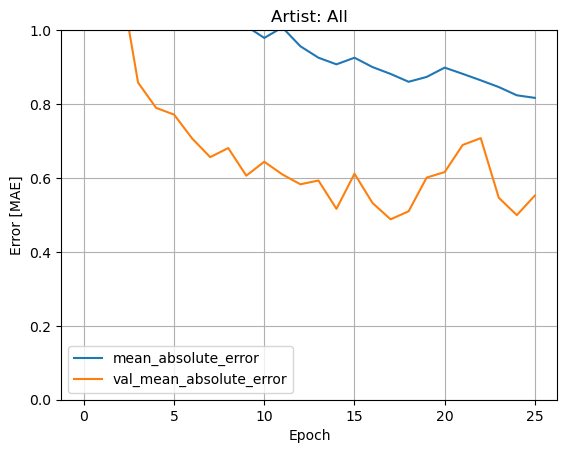

In [22]:
def plot_loss(history, artist=None):
    plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
    plt.plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
    plt.ylim([0, 1])
    plt.title(f"Artist: {artist}")
    plt.xlabel('Epoch')
    plt.ylabel('Error [MAE]')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history, 'All')

In [23]:
predictions = model.predict(X_test).flatten()

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


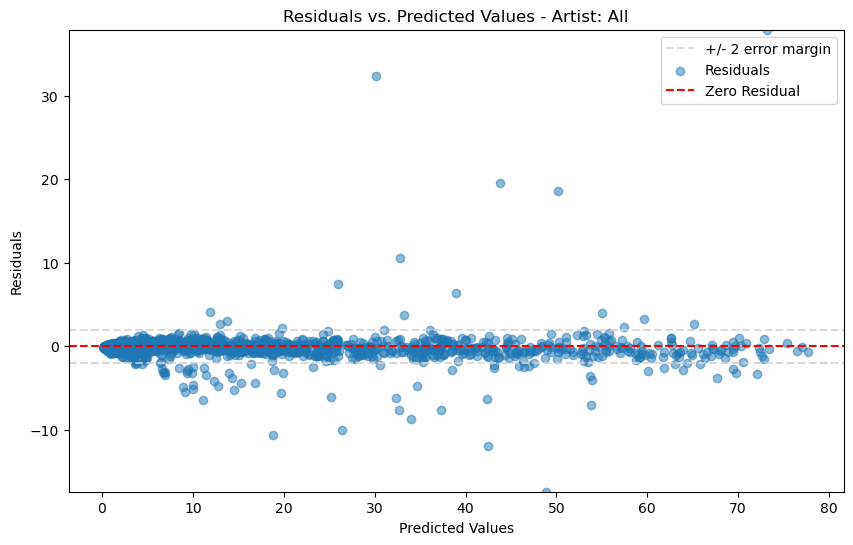

In [24]:
def plot_residuals(y, predictions, error_margin, artist=None):
    residuals = y - predictions.flatten()
    
    plt.figure(figsize=(10, 6))

    plt.axhline(y=error_margin, color='lightgrey', linestyle='--', alpha=0.8, label=f'+/- {error_margin} error margin')
    plt.axhline(y=-error_margin, color='lightgrey', linestyle='--', alpha=0.8)
    
    plt.scatter(predictions, residuals, alpha=0.5, label='Residuals')
    plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
    
    plt.ylim(min(residuals.min(), -error_margin * 1.1), max(residuals.max(), error_margin * 1.1))
    
    plt.title(f'Residuals vs. Predicted Values - Artist: {artist}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

plot_residuals(y_test, predictions, ERROR_MARGIN_G, artist='All')

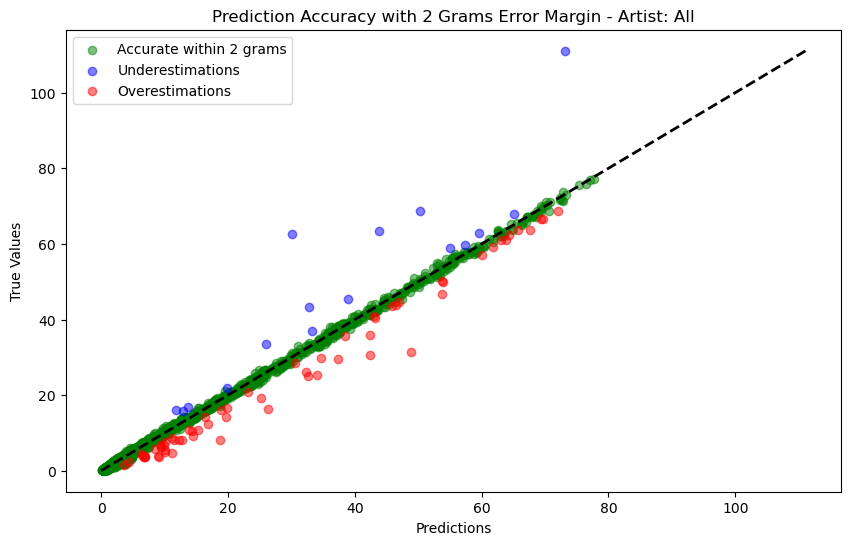

In [25]:
def plot_error_margin(y, predictions, error_margin, artist=None):
    residuals = np.abs(y - predictions)
    accurate_predictions = residuals <= error_margin
    underestimations = (y - predictions) > error_margin
    overestimations = (predictions - y) > error_margin
    
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions[accurate_predictions], y[accurate_predictions], color='green', alpha=0.5, label=f'Accurate within {error_margin} grams')
    plt.scatter(predictions[underestimations], y[underestimations], color='blue', alpha=0.5, label='Underestimations')
    plt.scatter(predictions[overestimations], y[overestimations], color='red', alpha=0.5, label='Overestimations')
    
    plt.xlabel('Predictions')
    plt.ylabel('True Values')
    plt.title(f'Prediction Accuracy with {error_margin} Grams Error Margin - Artist: {artist}')
    plt.legend()
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.show()

plot_error_margin(y_test, predictions, ERROR_MARGIN_G, artist='All')

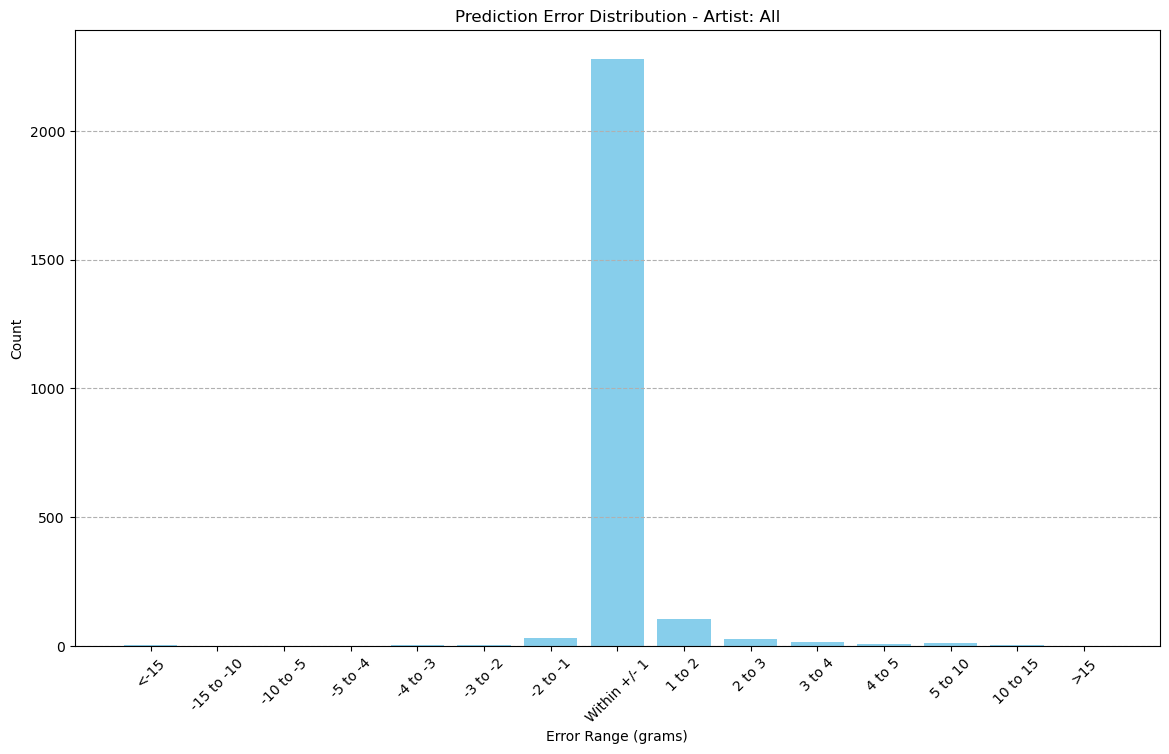

In [26]:
def plot_error_distribution(y_true, y_pred, artist=None):
    differences = y_pred - y_true

    boundaries = [(-np.inf, -15), (-15, -10), (-10, -5), (-5, -4), (-4, -3), (-3, -2), (-2, -1), (-1, 1),
                  (1, 2), (2, 3), (3, 4), (4, 5), (5, 10), (10, 15), (15, np.inf)]
    labels = ['<-15', '-15 to -10', '-10 to -5', '-5 to -4', '-4 to -3', '-3 to -2', '-2 to -1', 
              'Within +/- 1', 
              '1 to 2', '2 to 3', '3 to 4', '4 to 5', '5 to 10', '10 to 15', '>15']
    
    counts = np.zeros(len(labels))
    
    for i, (lower, upper) in enumerate(boundaries):
        if i == 7:  # Special case for 'Within +/- 1'
            counts[i] = np.sum((differences >= lower) & (differences < upper))
        else:
            counts[i] = np.sum((differences > lower) & (differences <= upper))
    
    non_zero_counts = counts > 0
    filtered_labels = np.array(labels)[non_zero_counts]
    filtered_counts = counts[non_zero_counts]

    plt.figure(figsize=(14, 8))
    plt.bar(filtered_labels, filtered_counts, color='skyblue')
    plt.xlabel('Error Range (grams)')
    plt.ylabel('Count')
    plt.title(f'Prediction Error Distribution - Artist: {artist}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--')
    plt.show()

plot_error_distribution(y_test, predictions, artist='All')

In [27]:
df_comparison = pd.DataFrame({'y_test':y_test, 'y_pred': predictions})

In [28]:
def get_results(predictions, y, error_margin=2, num_predictors=None, display=False):
    if num_predictors is None:
        raise ValueError("num_predictors must be provided to calculate adjusted R-squared.")
    
    n = len(y)
    p = num_predictors
    
    absolute_diff = np.abs(predictions - y)
    correct_predictions = np.sum(absolute_diff <= error_margin) / n * 100
    
    rmse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    r_squared = r2_score(y, predictions)
    adjusted_r_squared = 1 - (1-r_squared) * (n-1) / (n-p-1)

    if display:
        print(f"Percentage of predictions within {error_margin} grams of the actual values: {correct_predictions:.3f}%")
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")
        print(f"R-squared: {r_squared}")
        print(f"Adjusted R-squared: {adjusted_r_squared}\n")

    return correct_predictions

class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y, verbose=0)

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        results = self.model.evaluate(X, y, verbose=0)
        loss = results[0]
        return -loss

def plot_permutation_importance(model, X_test, y_test, seed, artist=None):
    wrapped_model = KerasRegressorWrapper(model)
    result = permutation_importance(wrapped_model, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=1)
    
    sorted_idx = result.importances_mean.argsort()
    plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
    plt.title(f'Prediction Error Distribution - Artist: {artist}')
    plt.xlabel("Permutation Importance")
    plt.show()

def calculate_differences(y_test, y_pred):
    differences = y_pred - y_test
    
    avg_difference = np.mean(np.abs(differences))
    min_difference = np.min(differences)
    max_difference = np.max(differences)
    
    print(f'Average difference: {avg_difference}, Minimum difference: {min_difference}, Maximum difference: {max_difference}')

def save_model(model, file_path, accuracy, accuracy_threshold=90):
    if accuracy > accuracy_threshold:
        model.save(file_path)
        print(f'Model saved as {file_path}')
    else:
        print(f"Model not saved, accuracy {accuracy:.3f} < {accuracy_threshold:.3f}")

def save_xgb_model(model, filename, accuracy, accuracy_threshold=0.9):
    if accuracy >= accuracy_threshold:
        joblib.dump(model, filename)
        print(f"Saved XGB model to {filename} (accuracy={accuracy:.3f})")
    else:
        print(f"Model not saved, accuracy {accuracy:.3f} < {accuracy_threshold:.3f}")

In [30]:
get_results(predictions, y_test, error_margin=ERROR_MARGIN_G-1, num_predictors=model.input_shape[1], display=True)
accuracy = get_results(predictions, y_test, error_margin=ERROR_MARGIN_G, num_predictors=model.input_shape[1], display=True)
get_results(predictions, y_test, error_margin=ERROR_MARGIN_G+1, num_predictors=model.input_shape[1], display=True)
calculate_differences(y_test, predictions)
save_model(best_model, f'./temp/minires-{round(accuracy, 3)}.keras', accuracy)

# plot_permutation_importance(model, X_test, y_test, SEED, artist='All')

Percentage of predictions within 1 grams of the actual values: 91.226%
RMSE: 2.294029346204344
MAE: 0.4956966077598433
R-squared: 0.9911824352547872
Adjusted R-squared: 0.9911540715563708

Percentage of predictions within 2 grams of the actual values: 96.795%
RMSE: 2.294029346204344
MAE: 0.4956966077598433
R-squared: 0.9911824352547872
Adjusted R-squared: 0.9911540715563708

Percentage of predictions within 3 grams of the actual values: 97.997%
RMSE: 2.294029346204344
MAE: 0.4956966077598433
R-squared: 0.9911824352547872
Adjusted R-squared: 0.9911540715563708

Average difference: 0.4956966077598433, Minimum difference: -37.91258392333984, Maximum difference: 17.419515228271486
Model saved as ./temp/minires-96.795.keras


In [31]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=SEED)

model_xgb = XGBRegressor(
    n_estimators=900,
    max_depth=9,
    learning_rate=0.01,
    subsample=0.7,
    colsample_bytree=0.9,
    random_state=SEED,
    n_jobs=-1,
    tree_method="hist",
    eval_metric="mae",
    early_stopping_rounds=50
)

model_xgb.fit(
    X_train_sub,
    y_train_sub,
    eval_set=[(X_val, y_val)],
    verbose=False
)

predictions_xgb = model_xgb.predict(X_test)
print("Test MAE:", mean_absolute_error(y_test, predictions_xgb))

Test MAE: 0.37783449713666084


In [32]:
get_results(predictions_xgb, y_test, error_margin=ERROR_MARGIN_G-1, num_predictors=X_test.shape[1], display=True)
accuracy_xgb = get_results(predictions_xgb, y_test, error_margin=ERROR_MARGIN_G, num_predictors=X_test.shape[1], display=True)
get_results(predictions_xgb, y_test, error_margin=ERROR_MARGIN_G+1, num_predictors=X_test.shape[1], display=True)
calculate_differences(y_test, predictions_xgb)
save_xgb_model(model_xgb, f"./temp/minires-{round(accuracy_xgb, 3)}.joblib", accuracy)

Percentage of predictions within 1 grams of the actual values: 91.867%
RMSE: 1.8576801054779901
MAE: 0.37783449713666084
R-squared: 0.9928596316202108
Adjusted R-squared: 0.9928366630045943

Percentage of predictions within 2 grams of the actual values: 96.595%
RMSE: 1.8576801054779901
MAE: 0.37783449713666084
R-squared: 0.9928596316202108
Adjusted R-squared: 0.9928366630045943

Percentage of predictions within 3 grams of the actual values: 98.397%
RMSE: 1.8576801054779901
MAE: 0.37783449713666084
R-squared: 0.9928596316202108
Adjusted R-squared: 0.9928366630045943

Average difference: 0.37783449713666084, Minimum difference: -32.90891075134277, Maximum difference: 15.389978027343751
Saved XGB model to ./temp/minires-96.595.joblib (accuracy=96.795)


In [33]:
def ensemble_predict(nn_model, xgb_model, X, w_nn=0.5):
    """
    Simple weighted average ensemble:
    y_hat = w_nn * y_hat_nn + (1 - w_nn) * y_hat_xgb
    """
    nn_pred = nn_model.predict(X).flatten()
    xgb_pred = xgb_model.predict(X)
    return w_nn * nn_pred + (1.0 - w_nn) * xgb_pred

def find_best_ensemble_weight(nn_model, xgb_model, X_val, y_val, num_steps=21):
    """
    Grid-search the best weight for the NN in [0, 1].
    Returns (best_w, best_mae).
    """
    nn_pred = nn_model.predict(X_val).flatten()
    xgb_pred = xgb_model.predict(X_val)

    best_w = None
    best_mae = float("inf")

    for w in np.linspace(0.0, 1.0, num_steps):
        blended = w * nn_pred + (1.0 - w) * xgb_pred
        mae = mean_absolute_error(y_val, blended)
        if mae < best_mae:
            best_mae = mae
            best_w = w

    return best_w, best_mae

In [34]:
# 1) Find best weight on the validation set
best_w, val_mae = find_best_ensemble_weight(model, model_xgb, X_val, y_val)
print(f"Best ensemble weight for NN: {best_w:.3f}, val MAE: {val_mae:.4f}")

# 2) Evaluate ensemble on the held-out test set
predictions_ensemble = ensemble_predict(model, model_xgb, X_test, w_nn=best_w)
ensemble_test_mae = mean_absolute_error(y_test, predictions_ensemble)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Best ensemble weight for NN: 0.200, val MAE: 0.3767
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [35]:
get_results(predictions_ensemble, y_test, error_margin=ERROR_MARGIN_G-1, num_predictors=X_test.shape[1], display=True)
accuracy_ensemble = get_results(predictions_ensemble, y_test, error_margin=ERROR_MARGIN_G, num_predictors=X_test.shape[1], display=True)
get_results(predictions_ensemble, y_test, error_margin=ERROR_MARGIN_G+1, num_predictors=X_test.shape[1], display=True)
get_results(predictions_ensemble, y_test, error_margin=ERROR_MARGIN_G+3, num_predictors=X_test.shape[1], display=True)
calculate_differences(y_test, predictions_ensemble)

Percentage of predictions within 1 grams of the actual values: 92.508%
RMSE: 1.848510565559515
MAE: 0.372776079013084
R-squared: 0.9928948765973724
Adjusted R-squared: 0.9928720213552248

Percentage of predictions within 2 grams of the actual values: 96.995%
RMSE: 1.848510565559515
MAE: 0.372776079013084
R-squared: 0.9928948765973724
Adjusted R-squared: 0.9928720213552248

Percentage of predictions within 3 grams of the actual values: 98.438%
RMSE: 1.848510565559515
MAE: 0.372776079013084
R-squared: 0.9928948765973724
Adjusted R-squared: 0.9928720213552248

Percentage of predictions within 5 grams of the actual values: 99.199%
RMSE: 1.848510565559515
MAE: 0.372776079013084
R-squared: 0.9928948765973724
Adjusted R-squared: 0.9928720213552248

Average difference: 0.372776079013084, Minimum difference: -32.796177291870116, Maximum difference: 15.795885467529295


In [38]:
ensemble_meta = {
    "w_nn": float(best_w),
    "features": list(features),
}
with open(f"./temp/minires-{round(accuracy_ensemble, 3)}.json", "w") as f:
    json.dump(ensemble_meta, f, indent=2)

print(f"Saved: minires-{round(accuracy_ensemble, 3)}.json")

Saved: minires-96.995.json
